In [1]:
import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import nbformat
import plotly
import bokeh

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/forrestwilliams/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/forrestwilliams/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
mgp_tweets = pd.read_csv('data/mgp_full_tweets.csv')

# Latent Dirichlet Allocation (LDA)  on Term Frequency-Inverse Document Frequency (TF-IDF)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# `mgp_tweets['text']` contains the raw tweet texts
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

tfidf = vectorizer.fit_transform(mgp_tweets['text'])
feature_names = vectorizer.get_feature_names_out()


In [4]:
num_topics = 5  # adjust number of topics

lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_W = lda_model.fit_transform(tfidf)
lda_H = lda_model.components_


In [5]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 30
display_topics(lda_model, feature_names, num_top_words)


Topic 1:
https | joe | kent | pro | election | ballot | like | campaign | doors | join | volunteers | volunteer | people | right | marieforcongress | vancouver | sign | women | voting | safe | want | choice | vote | democracy | ll | 8pm | com | thanks | watch | future
Topic 2:
https | flip | kent | joe | help | rt | wa03 | congress | choice | november | blue | seat | mgpforcongress | amp | running | working | make | money | need | small | race | white | owner | ad | big | washington | join | district | mother | true
Topic 3:
people | day | thank | county | congress | campaign | https | like | democrats | fight | voices | represent | cowlitz | warren | fix | today | letter | wonderful | good | continues | capitol | funded | bring | support | dinner | looks | washington | movement | years | ve
Topic 4:
https | tonight | support | honored | thank | endorsement | country | climate | work | republicans | working | today | listen | democracy | debate | joe | herrerabeutler | like | kent | go

In [15]:
# Assign the dominant topic to each tweet
mgp_tweets['dominant_topic'] = np.argmax(lda_W, axis=1)


In [16]:
top_tweets = 20  # Number of top tweets to display for each topic

for topic_idx in range(num_topics):
    print(f"\nTopic {topic_idx + 1}:")
    # Get the indexes of tweets that belong to the current topic
    indexes = np.where(mgp_tweets['dominant_topic'] == topic_idx)[0]
    # Sort the indexes by their strength association with the topic
    sorted_indexes = indexes[np.argsort(lda_W[:, topic_idx][indexes])[::-1]]
    # Print the top tweets for the topic
    for i in sorted_indexes[:top_tweets]:
        print(f" - {mgp_tweets.iloc[i]['text']}")



Topic 1:
 - Joe Kent:

💰 “Forgot” who’s paying his salary (we still don’t know)
❌ Has only a “phantom job”, says his ex-campaign manager
👮‍♀️ Wants to defund the FBI, who investigate federal election crimes

Tomorrow @OPBTOL hosts the final #WA03 debate. Joe has a lot of questions to answer.
 - Joe Kent thinks we should end mail-in voting in Washington State. 

Vote-by-mail is safe, secure, and Washingtonians don’t want to go back.​​

Join us this Friday for a voting rights rally in Esther Short Park 🪧 🗳 

RSVP Here: https://t.co/EXFsmRHVJ5
 - The stakes couldn’t be higher in this election. We’re running against a field of anti-choice extremists. Join us calling voters across the district to make sure they turn in their ballot before August 2nd. Register to volunteer here: https://marieforcongress.com/volunteer/
 - It’s Election Day. I’ve cast my vote and I hope I’ve done everything to earn yours.

As a pro-choice mom who runs an auto shop, I'll be an independent voice for working fam

In [17]:
mgp_tweets.columns

Index(['Unnamed: 0', 'date', 'text', 'dominant_topic'], dtype='object')

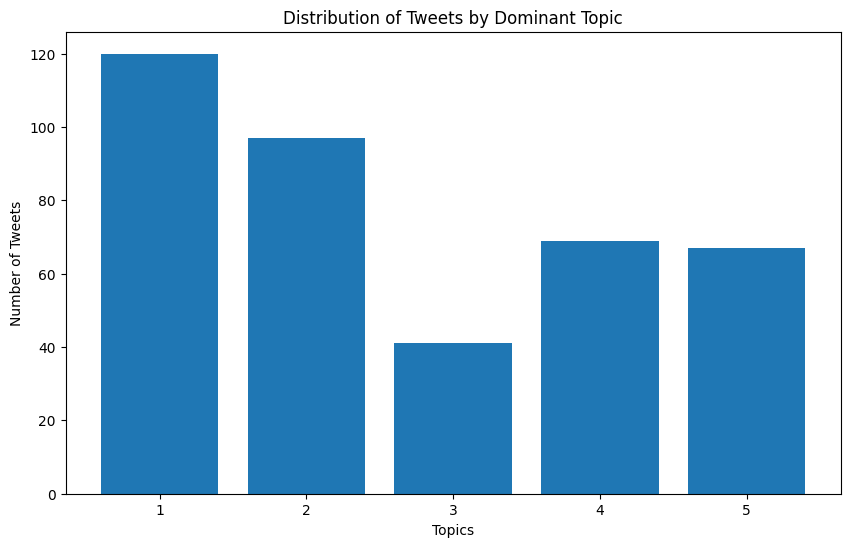

In [18]:
import matplotlib.pyplot as plt

# Count the number of tweets in each topic
tweet_counts = mgp_tweets['dominant_topic'].value_counts().sort_index()

# Create simple bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_topics + 1), tweet_counts)
plt.xlabel('Topics')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets by Dominant Topic')
plt.xticks(range(1, num_topics + 1))
plt.show()


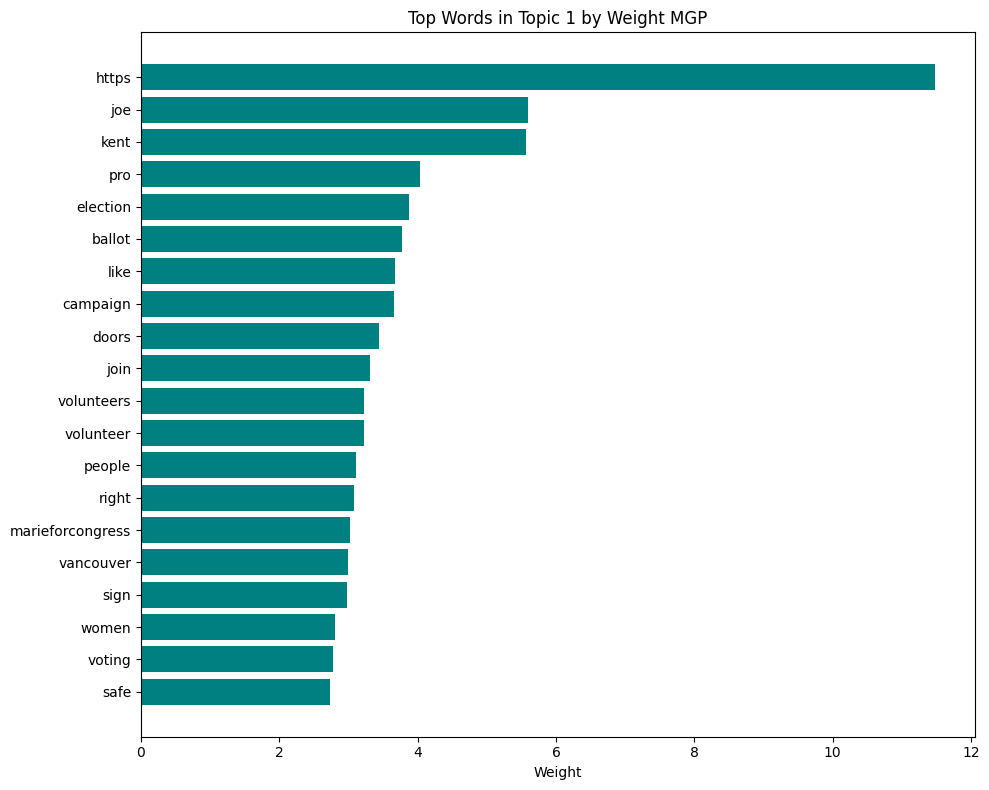

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_words_for_first_topic(model, feature_names, num_top_words, filename='mgp_topic1.png'):
    # Extract the weights for the first topic
    topic_weights = model.components_[0]
    
    # Get the indices of the top words in this topic
    top_indices = topic_weights.argsort()[-num_top_words:][::-1]
    
    # Extract the top words and their corresponding weights
    top_words = [feature_names[i] for i in top_indices]
    weights = [topic_weights[i] for i in top_indices]
    
    # Plotting
    y_pos = np.arange(len(top_words))
    
    plt.figure(figsize=(10, 8))
    plt.barh(y_pos, weights, align='center', color='#008080')  # Change the color here
    plt.yticks(y_pos, top_words)
    plt.gca().invert_yaxis()  # To display the highest weights at the top
    plt.xlabel('Weight')
    plt.title('Top Words in Topic 1 by Weight MGP')
    
    # Save the figure before showing it
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.savefig(filename)
    
    # Then display the plot
    plt.show()

# Now call the function with the necessary arguments
plot_top_words_for_first_topic(lda_model, feature_names, 20)


# Latent Semantic Analysis (LSA) on tweet matrix GloVe vectors

In [21]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/forrestwilliams/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/forrestwilliams/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/forrestwilliams/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/forrestwilliams/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [27]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# download the nltk stop and punctuation packages
nltk.download('punkt')
nltk.download('stopwords')

# reload CSV file
mgp_tweets = pd.read_csv('data/mgp_full_tweets.csv')

# preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text)
    
    # Lowercase and remove stopwords
    tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stopwords.words('english')]
    
    return tokens

# create new column for processed tweets from raw tweet 'text'column
mgp_tweets['processed_tweets'] = mgp_tweets['text'].apply(preprocess_text)



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/forrestwilliams/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/forrestwilliams/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
from gensim.downloader import load

glove_model = load("glove-twitter-100")


[===-----------------------------------------------] 6.1% 23.4/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 25.0% 96.9/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 43.3% 167.5/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============================----------------------] 57.9% 224.0/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===================================---------------] 70.7% 273.7/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=========================================---------] 83.0% 321.4/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.0% 367.9/387.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [30]:
# Function to convert tokens to vectors using the GloVe model
def tokens_to_vectors(tokens, model):
    vectors = []
    for token in tokens:
        if token in model.key_to_index:
            vectors.append(model[token])
    return vectors

# Vectorize the tokenized tweets
mgp_tweets['tweet_vectors'] = mgp_tweets['processed_tweets'].apply(lambda tokens: tokens_to_vectors(tokens, glove_model))

# Check the results
print(mgp_tweets['tweet_vectors'].head())


0    [[-0.11318, 0.5062, -0.049727, -0.6019, -0.220...
1    [[-0.00065223, -0.12034, 0.46303, 0.26886, -0....
2    [[0.083388, 0.78767, 0.13946, 0.087604, 0.2119...
3    [[0.14647, -0.396, 0.59402, 0.19365, 0.04788, ...
4    [[-0.00010287, 0.61486, 0.10247, 0.8551, -0.82...
Name: tweet_vectors, dtype: object


In [31]:
import numpy as np

# Function to calculate the average vector for each tweet
def average_vectors(vectors):
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # return a zero vector if there are no vectors
        return np.zeros(glove_model.vector_size)

# Apply function to average the vectors for each tweet in new column 'average_vector'
mgp_tweets['average_vector'] = mgp_tweets['tweet_vectors'].apply(average_vectors)

# check the results
print(mgp_tweets['average_vector'].head())


0    [0.056651592, 0.27764928, 0.09045536, -0.07547...
1    [0.042626698, 0.4640896, -0.05916787, -0.24449...
2    [-0.15714599, 0.5316516, 0.08266478, -0.285243...
3    [0.057770632, 0.15924203, 0.07209626, -0.16738...
4    [0.15329082, 0.6445816, -0.040088523, 0.037500...
Name: average_vector, dtype: object


In [32]:
# stack all average vectors to create the matrix for SVD
tweet_matrix = np.vstack(mgp_tweets['average_vector'])

# Check the shape of the matrix (it should have as many rows as tweets and as many columns as dimensions in the GloVe vectors)
print(tweet_matrix.shape)


(394, 100)


# Truncated SVD **note** 
I used this cause it can handle the negative values of vector, but it just wasn't any good

In [33]:
from sklearn.decomposition import TruncatedSVD


num_topics = 7  

# Perform Truncated SVD on the tweet_matrix
svd_model = TruncatedSVD(n_components=num_topics, random_state=42)
U = svd_model.fit_transform(tweet_matrix)  # U now contains your tweet-topic association




In [34]:
import numpy as np

num_top_tweets = 15  # Number of top tweets you want to examine per topic

# Loop through each component
for i in range(num_topics):
    # Get the column for the current component
    component = U[:, i]
    
    # Get the indices that would sort this component
    sorted_indices = np.argsort(component)[::-1]
    
    print(f"Top tweets for Component {i+1}:")

    # Display the top tweets for this component
    for idx in sorted_indices[:num_top_tweets]:
        print(f" - {mgp_tweets.iloc[idx]['text']}")
    print("\n" + "-"*50 + "\n")


Top tweets for Component 1:
 - #DogsforMarie
 - Camas Canvass: https://mobilize.us/s/g7FqL1
 - RT @DianaCCastaneda: La opción es clara #WA03 @MGPforCongress quiere mejorar:
➡️ Nuestra economía 
➡️ Inflación y costo de vida 
➡️ Educaci…
 - #LlamasforMarie 🦙🦙 https://t.co/VkxD7lnzDJ
 - https://t.co/G7nazDJybh
 - https://olvr.votewa.gov
 - RSVP for Longview: https://mobilize.us/s/4wUjtq
 - RSVP for Longview: https://mobilize.us/s/4wUjtq
 - Here’s the transcript: 

https://t.co/RzgLHGJsKM https://t.co/DOaYSAtZQo
 - Be on the lookout 🏍 https://t.co/vGDWDAfNfd
 - RT @LetAmericaVote: In #WA03, we're endorsing #NoCorporatePAC Democratic candidate @MGPforCongress. https://t.co/KeonZ1X6BZ
 - RSVP for Vancouver: https://mobilize.us/s/Nu88rk
 - RSVP for Vancouver: https://mobilize.us/s/Nu88rk
 - Winona Ryder here wishing you a Happy Halloween 🎃 https://t.co/s6UOlXqIWu
 - Sign up for a canvassing shift here: https://t.co/4ihF9llC04

--------------------------------------------------

Top tweets for

# still need to make these positive 

In [35]:
# Convert the U matrix to absolute values before summing
topic_sums_abs = np.sum(np.abs(U), axis=0)  # Sum over each topic column using absolute values
total_sum_abs = np.sum(topic_sums_abs)  # Total sum of all associations using absolute values
topic_proportions_abs = topic_sums_abs / total_sum_abs  # Normalize to get proportions

# These proportions are now all positive and can be visualized directly

# Square the U matrix before summing
topic_sums_squared = np.sum(np.square(U), axis=0)  # Sum over each topic column using squared values
total_sum_squared = np.sum(topic_sums_squared)  # Total sum of all associations using squared values
topic_proportions_squared = topic_sums_squared / total_sum_squared  # Normalize to get proportions

# These proportions are based on squared values, ensuring positivity



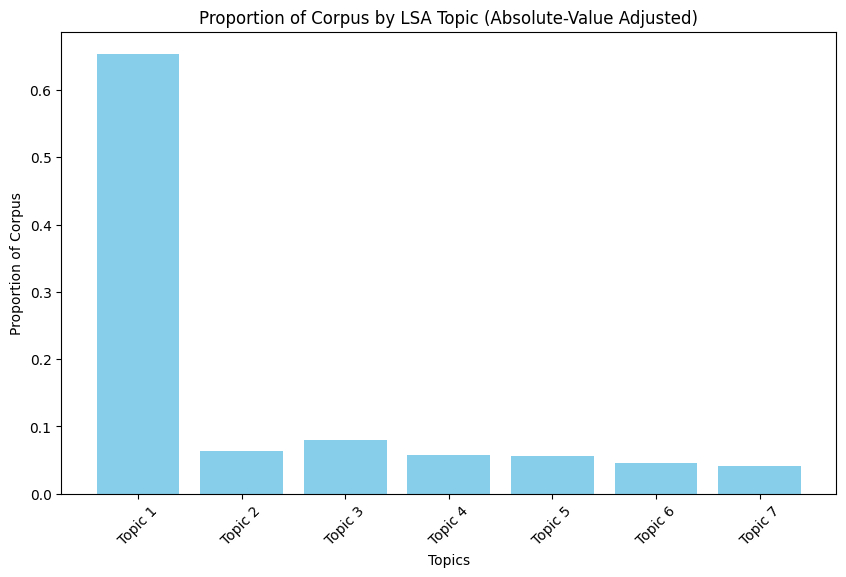

In [36]:
#simple bar chart
topic_labels = [f"Topic {i+1}" for i in range(num_topics)]
plt.figure(figsize=(10, 6))
plt.bar(topic_labels, topic_proportions_abs, color='skyblue') 
plt.xlabel('Topics')
plt.ylabel('Proportion of Corpus')
plt.title('Proportion of Corpus by LSA Topic (Absolute-Value Adjusted)')
plt.xticks(rotation=45)
plt.show()


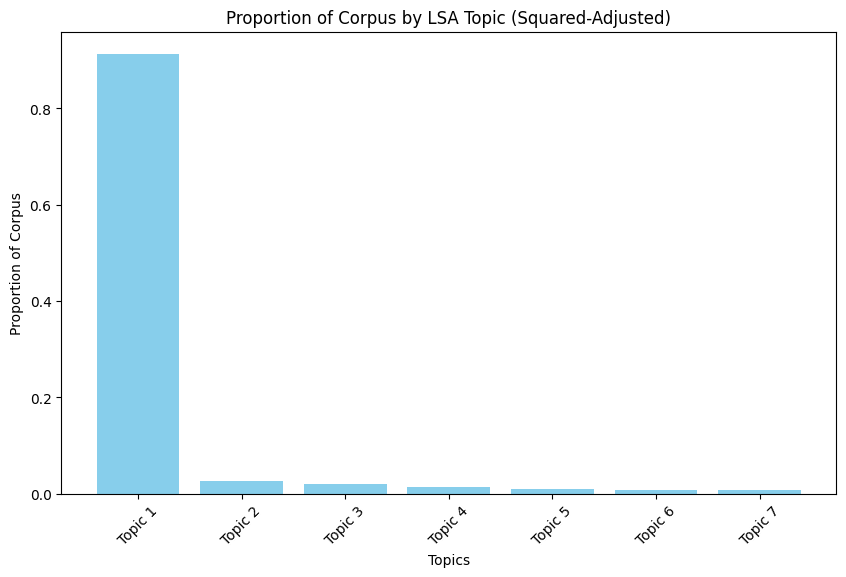

In [37]:
plt.figure(figsize=(10, 6))
plt.bar(topic_labels, topic_proportions_squared, color='skyblue')  # or use topic_proportions_squared
plt.xlabel('Topics')
plt.ylabel('Proportion of Corpus')
plt.title('Proportion of Corpus by LSA Topic (Squared-Adjusted)')
plt.xticks(rotation=45)
plt.show()


# GloVe and NMF

### Don't need to do too much preprocessing here because it's vectorizing full words based on the tweet context

In [38]:
# Load CSV file
mgp_tweets = pd.read_csv('data/mgp_full_tweets.csv')

# preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text)
    
    # Lowercase and remove stopwords
    tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stopwords.words('english')]
    
    return tokens

# new column for processed tweets to vectorize
mgp_tweets['processed_tweets'] = mgp_tweets['text'].apply(preprocess_text)

# Check the processed tweets
print(mgp_tweets['processed_tweets'].head())


0    [pacific, county, home, skamania, everywhere, ...
1    [making, calls, online, amp, person, starting,...
2    [everyone, pitched, make, campaign, strong, to...
3    [comparing, weird, rally, january, dunk, think...
4    [want, get, know, stand, watch, video, candida...
Name: processed_tweets, dtype: object


### Later on when I need to do visualizaitons, I need to make sure long tweets have linebreaks in them for viewing on the plot

In [39]:
def insert_line_breaks(text, char_limit=50):
    words = text.split()
    processed_text = ""
    current_length = 0
    
    for word in words:
        if current_length + len(word) + 1 > char_limit:
            processed_text += "<br>"
            current_length = 0
        processed_text += word + " "
        current_length += len(word) + 1  # Account for the space
    
    return processed_text.strip()

# new column with the broken up tweets
mgp_tweets['tweet_text_with_breaks'] = mgp_tweets['text'].apply(insert_line_breaks)

# Verify the results
print(mgp_tweets[['text', 'tweet_text_with_breaks']].head())


                                                text  \
0  From Pacific County, to my home in Skamania an...   
1  We’ll be making calls online &amp; in person s...   
2  For everyone who has pitched in to make our ca...   
3  Comparing your weird rally to January 6th is n...   
4  If you want to get to know me and what I stand...   

                              tweet_text_with_breaks  
0  From Pacific County, to my home in Skamania an...  
1  We’ll be making calls online &amp; in person <...  
2  For everyone who has pitched in to make our <b...  
3  Comparing your weird rally to January 6th is n...  
4  If you want to get to know me and what I stand...  


### Vectorization with GloVe

We use the GloVe model, trained on 2 billion tweets, for word vectorization. This model yields 100-dimensional vectors, which encode semantic relationships between words specifically on Twitter, making this form of vectorization more suitable for capturing the meaning behind how language is being used on Twitter.

Here we:
1. **Glove Model and Vectors**: The pre-trained GloVe model is loaded to map tweet tokens to vectors.
2. **Token Vectorization**: Each token in a tweet is converted to its corresponding 100-dimensional GloVe vector. Tokens not found in the GloVe vocabulary are omitted.
3. **Vector Storage**: The vectors for each tweet are aggregated and stored


In [41]:
# Function to convert tokens to vectors using the GloVe model
def tokens_to_vectors(tokens, model):
    vectors = []
    for token in tokens:
        # Check if the token exists in the GloVe model
        if token in model.key_to_index:
            vectors.append(model[token])
        else:
            # Handle out-of-vocabulary tokens if necessary, e.g., by ignoring them or using a placeholder
            pass
    return vectors

# Apply the function to your tokenized tweets
mgp_tweets['tweet_vectors'] = mgp_tweets['processed_tweets'].apply(lambda tokens: tokens_to_vectors(tokens, glove_model))

# Check the result
print(mgp_tweets['tweet_vectors'].head())


0    [[-0.11318, 0.5062, -0.049727, -0.6019, -0.220...
1    [[-0.00065223, -0.12034, 0.46303, 0.26886, -0....
2    [[0.083388, 0.78767, 0.13946, 0.087604, 0.2119...
3    [[0.14647, -0.396, 0.59402, 0.19365, 0.04788, ...
4    [[-0.00010287, 0.61486, 0.10247, 0.8551, -0.82...
Name: tweet_vectors, dtype: object


### Averaging GloVe Vectors
For each tweet, we average its token vectors into a single 100-dimensional vector, simplifying analysis. Tweets without valid tokens receive a zero vector.

In [42]:
import numpy as np

# Function to calculate the average vector for each tweet
def average_vectors(vectors):
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # Return a zero vector if there are no vectors
        return np.zeros(glove_model.vector_size)

# Apply the function to average the vectors for each tweet
mgp_tweets['average_vector'] = mgp_tweets['tweet_vectors'].apply(average_vectors)

# Check the result
print(mgp_tweets['average_vector'].head())


0    [0.056651592, 0.27764928, 0.09045536, -0.07547...
1    [0.042626698, 0.4640896, -0.05916787, -0.24449...
2    [-0.15714599, 0.5316516, 0.08266478, -0.285243...
3    [0.057770632, 0.15924203, 0.07209626, -0.16738...
4    [0.15329082, 0.6445816, -0.040088523, 0.037500...
Name: average_vector, dtype: object


### Stack the Vectors to create the matrix for NMF

In [43]:
# Stack all average vectors to create the matrix for NMF
tweet_matrix = np.vstack(mgp_tweets['average_vector'])

# Check the shape of the matrix (it should have as many rows as tweets and as many columns as dimensions in the GloVe vectors)
print(tweet_matrix.shape)


(394, 100)


# Non-Negative Matrix Factorization (NMF) 

As suggested by its name, NMF requires non-negative data. I chose to apply the absolute value to handle this because it preserves the magnitude of vector components. This step enables decomposition into tweet-topic and topic-term matrices and should be more accurate at recognizing topics than LDA with TF-IDF, which uses word frequency/rarity scores


In [44]:
num_topics = 7 #Keeping in a stand-alone cell for iteration purposes

In [45]:
# Apply the absolute value to the tweet matrix
tweet_matrix_abs = np.abs(tweet_matrix)

# Then apply NMF as before
nmf_model = NMF(n_components=num_topics, random_state=42)
W_abs = nmf_model.fit_transform(tweet_matrix_abs)  # Tweet-topic matrix
H_abs = nmf_model.components_  # Topic-term matrix

print(W_abs.shape)  # (number of tweets, number of topics)
print(H_abs.shape)  # (number of topics, vector dimensions)


(394, 7)
(7, 100)


/Users/forrestwilliams/miniforge3/envs/bokeh-env/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


### Examine top tweets for each topic

Next, I print the top 50 tweets associated with each topic to help determine the connecting characteristics and assign a topic title. But before I assign the titles, I will also consider the distribution as graphed below.

In [46]:
# Number of top tweets to display for each topic
top_tweets = 50

for topic_idx, topic in enumerate(H_abs):
    print(f"Topic {topic_idx + 1}:\n")

    # Get indices of top tweets for this topic
    top_tweet_indices = W_abs[:, topic_idx].argsort()[-top_tweets:][::-1]

    for tweet_idx in top_tweet_indices:
        print(f" - {mgp_tweets.iloc[tweet_idx]['text']}")
    
    print("\n" + "-"*50 + "\n")


Topic 1:

 - We’re going to flip #WA03 with the support of folks just like you- thanks to everyone who came out tonight. Looking forward to Camas Days Parade tomorrow!
 - The voices of ordinary, working people are missing from Congress and things won’t get better until people like us are elected.

There are two more days to get your ballot in. 🗳 Together we can make the system work for working people.
 - Looking forward to dinner with the Skamania County Democrats tonight.

This is what a truly people-powered movement looks like!
 - So much fun in Pacific County today. Thank you to everyone who came out in Ilwaco & Raymond!
 - Election Day is one week away! This is not a race that you want to sit in the back seat and observe. There is far too much at stake. 

There is still time to make a difference. Don’t watch the news a week from today and wish you had done more. Sign up now: https://t.co/4ihF9l4yY4
 - Great turn out at the Camas Days Parade. Thanks to everyone who walked with us & 

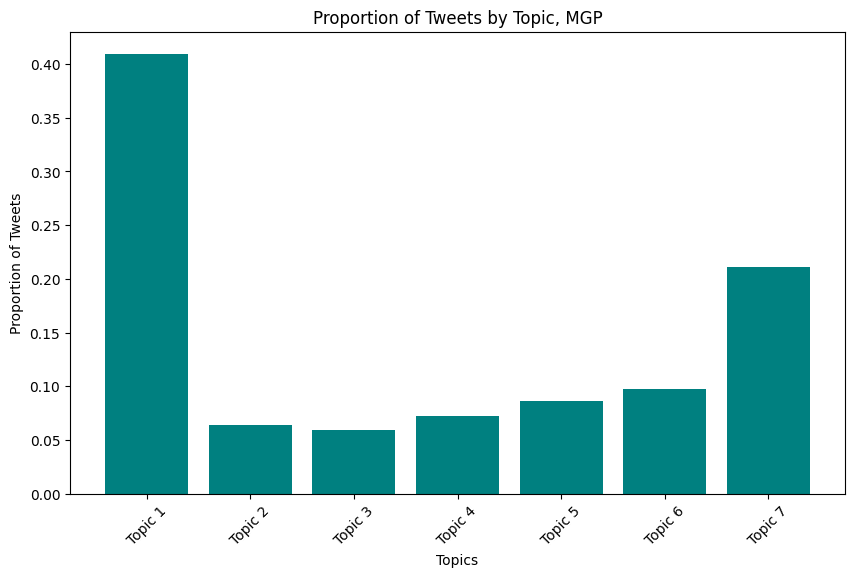

In [47]:
import matplotlib.pyplot as plt

# Calculate the sum of associations for each topic
topic_sums = W_abs.sum(axis=0)

# Normalize to get proportions
topic_proportions = topic_sums / topic_sums.sum()

# Topic labels (you can customize these to be more descriptive)
topic_labels = [f"Topic {i+1}" for i in range(num_topics)]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(topic_labels, topic_proportions, color='#008080')
plt.xlabel('Topics')
plt.ylabel('Proportion of Tweets')
plt.title('Proportion of Tweets by Topic, MGP')
plt.xticks(rotation=45)
plt.savefig('mgp_topic_distribution.png')
plt.show()


In [48]:
# Assuming `W_abs` is the document-topic matrix from NMF
mgp_tweets['dominant_topic'] = np.argmax(W_abs, axis=1)


In [49]:
mgp_tweets['dominant_topic'].value_counts()

dominant_topic
0    323
6     52
1      7
3      5
4      4
5      2
2      1
Name: count, dtype: int64

In [50]:
tweet_index = 0  # Example index of a tweet
tweet_topic_association = W_abs[tweet_index, :]
print(f"Associations of tweet {tweet_index} with topics: {tweet_topic_association}")


Associations of tweet 0 with topics: [0.38743935 0.02180776 0.04528295 0.10475636 0.05065225 0.01073522
 0.03042468]


In [51]:
tweet_text = mgp_tweets.iloc[0]['text']
print(f"Tweet 0: {tweet_text}")

Tweet 0: From Pacific County, to my home in Skamania and everywhere in between, voters have stood up for women, working families, and our democracy.

Today is when we bring our hard work home. Get your ballots in before 8 pm tonight so we can win this thing! https://t.co/Z3T6Uc15hf


## Create New Analysis Dataframe incorporating topic titles and linebreak tweets for later visualization

In [52]:
# After qualitative review of the top 50 tweets in each category, I feel like these titles
# encompass the overall unifying theme of the topic
topic_names = [
    "Voice for Working Class",
    "Digital & Community Engagement",
    "Endorsements & Policy Priorities",
    "Voter Mobilization Efforts",
    "Anti-Extremism",
    "Volunteer & Fundraising",
    "Defending Rights & Freedoms"
]

# Create a new DataFrame for analysis
analysis_df = pd.DataFrame()

# Add the unprocessed tweet texts and tweet texts with line breaks
analysis_df['tweet_text'] = mgp_tweets['text']
analysis_df['tweet_text_with_breaks'] = mgp_tweets['tweet_text_with_breaks']  # Include the column with line breaks

# Add the association values for each topic with custom column names
for i, topic_name in enumerate(topic_names):
    analysis_df[topic_name] = W_abs[:, i]

analysis_df.head()


,tweet_text,tweet_text_with_breaks,Voice for Working Class,Digital & Community Engagement,Endorsements & Policy Priorities,Voter Mobilization Efforts,Anti-Extremism,Volunteer & Fundraising,Defending Rights & Freedoms
0,"From Pacific County, to my home in Skamania an...","From Pacific County, to my home in Skamania an...",0.387439,0.021808,0.045283,0.104756,0.050652,0.010735,0.030425
1,We’ll be making calls online &amp; in person s...,We’ll be making calls online &amp; in person <...,0.352840,0.006585,0.000000,0.065174,0.020219,0.176821,0.131708
2,For everyone who has pitched in to make our ca...,For everyone who has pitched in to make our <b...,0.334047,0.000000,0.000000,0.158266,0.000095,0.093510,0.182293
3,Comparing your weird rally to January 6th is n...,Comparing your weird rally to January 6th is n...,0.277374,0.056747,0.067059,0.038374,0.054035,0.001728,0.017456
4,If you want to get to know me and what I stand...,If you want to get to know me and what I stand...,0.344661,0.000000,0.000048,0.103605,0.000000,0.215929,0.253562


In [53]:
import pandas as pd

# Set the maximum column width to, say, 400 characters
pd.set_option('display.max_colwidth', 1000)

# Now when you display the DataFrame, the 'tweet_text' column should show more content
analysis_df.head()

,tweet_text,tweet_text_with_breaks,Voice for Working Class,Digital & Community Engagement,Endorsements & Policy Priorities,Voter Mobilization Efforts,Anti-Extremism,Volunteer & Fundraising,Defending Rights & Freedoms
0,"From Pacific County, to my home in Skamania and everywhere in between, voters have stood up for women, working families, and our democracy.\n\nToday is when we bring our hard work home. Get your ballots in before 8 pm tonight so we can win this thing! https://t.co/Z3T6Uc15hf","From Pacific County, to my home in Skamania and <br>everywhere in between, voters have stood up for <br>women, working families, and our democracy. Today <br>is when we bring our hard work home. Get your <br>ballots in before 8 pm tonight so we can win this <br>thing! https://t.co/Z3T6Uc15hf",0.387439,0.021808,0.045283,0.104756,0.050652,0.010735,0.030425
1,We’ll be making calls online &amp; in person starting at 4:00 pm to get those last votes in. I hope you can join! Sign up for both here: https://t.co/4ihF9l4yY4,We’ll be making calls online &amp; in person <br>starting at 4:00 pm to get those last votes in. I <br>hope you can join! Sign up for both here: <br>https://t.co/4ihF9l4yY4,0.352840,0.006585,0.000000,0.065174,0.020219,0.176821,0.131708
2,"For everyone who has pitched in to make our campaign as strong as it is today, I’ll be at the Hilton in downtown Vancouver tonight at 7 pm. \n\nCome join me and celebrate all of our hard work as we watch the election results come in! RSVP here: https://t.co/tvDvGiUFUg","For everyone who has pitched in to make our <br>campaign as strong as it is today, I’ll be at the <br>Hilton in downtown Vancouver tonight at 7 pm. <br>Come join me and celebrate all of our hard work <br>as we watch the election results come in! RSVP <br>here: https://t.co/tvDvGiUFUg",0.334047,0.000000,0.000000,0.158266,0.000095,0.093510,0.182293
3,"Comparing your weird rally to January 6th is not the dunk you think it is, bucko https://t.co/ZXAUjAc9RK","Comparing your weird rally to January 6th is not <br>the dunk you think it is, bucko <br>https://t.co/ZXAUjAc9RK",0.277374,0.056747,0.067059,0.038374,0.054035,0.001728,0.017456
4,"If you want to get to know me and what I stand for, watch this video. \n\nIf I’m your candidate after watching, please share and retweet to help more people see.\n\nMost of all, please VOTE and return your ballot by 8pm 🗳 https://t.co/FD3kmhORKq","If you want to get to know me and what I stand <br>for, watch this video. If I’m your candidate <br>after watching, please share and retweet to help <br>more people see. Most of all, please VOTE and <br>return your ballot by 8pm 🗳 <br>https://t.co/FD3kmhORKq",0.344661,0.000000,0.000048,0.103605,0.000000,0.215929,0.253562


In [54]:
sorted_topic_dfs = {}  # Initialize an empty dictionary to store sorted DataFrames for each topic

# Loop over all topic names and create a sorted DataFrame for each topic
for topic_name in topic_names:
    sorted_df = analysis_df.sort_values(by=topic_name, ascending=False)  # Sort by the current topic
    sorted_topic_dfs[topic_name] = sorted_df  # Store the sorted DataFrame in the dictionary


In [55]:
def display_top_tweets(topic_input, top_n=5):
    """
    Displays the top N tweets for a given topic or custom column along with their association strengths for all topics.

    Parameters:
    - topic_input: Can be the exact name of the topic, a format like 'Topic_1', or a custom column like 'Anti-Extremism'.
    - top_n: The number of top tweets to display (default is 5).
    """
    # Handling custom column names like 'Anti-Extremism'
    if topic_input in analysis_df.columns:
        # If the input is a direct column name, use it to sort and display top tweets
        sorted_df = analysis_df.sort_values(by=topic_input, ascending=False)
        return sorted_df.head(top_n)[['tweet_text'] + topic_names + [topic_input]]
    
    # Existing logic to handle topic names and 'Topic_X' formats
    elif topic_input.startswith("Topic_"):
        try:
            index = int(topic_input.split('_')[1]) - 1  # Convert 'Topic_X' to an index
            topic_name = topic_names[index]
        except (IndexError, ValueError):
            print(f"Invalid topic input: '{topic_input}'. Please use a valid topic number or name.")
            return
    else:
        topic_name = topic_input
    
    if topic_name in topic_names:
        sorted_df = sorted_topic_dfs[topic_name]
        return sorted_df.head(top_n)[['tweet_text'] + topic_names]
    else:
        print(f"Topic '{topic_name}' not found.")


In [56]:
# Using the format 'Topic_X'
display_top_tweets('Topic_1', 30)

,tweet_text,Voice for Working Class,Digital & Community Engagement,Endorsements & Policy Priorities,Voter Mobilization Efforts,Anti-Extremism,Volunteer & Fundraising,Defending Rights & Freedoms
335,We’re going to flip #WA03 with the support of folks just like you- thanks to everyone who came out tonight. Looking forward to Camas Days Parade tomorrow!,0.421365,0.032378,0.007832,0.113643,0.000000,0.076491,0.070599
16,"The voices of ordinary, working people are missing from Congress and things won’t get better until people like us are elected.\n\nThere are two more days to get your ballot in. 🗳 Together we can make the system work for working people.",0.419940,0.006166,0.036958,0.043368,0.013162,0.000000,0.280912
220,Looking forward to dinner with the Skamania County Democrats tonight.\n\nThis is what a truly people-powered movement looks like!,0.412211,0.006120,0.062816,0.096168,0.029001,0.056883,0.046089
333,So much fun in Pacific County today. Thank you to everyone who came out in Ilwaco & Raymond!,0.406292,0.024844,0.026859,0.125479,0.040825,0.064167,0.031817
40,Election Day is one week away! This is not a race that you want to sit in the back seat and observe. There is far too much at stake. \n\nThere is still time to make a difference. Don’t watch the news a week from today and wish you had done more. Sign up now: https://t.co/4ihF9l4yY4,0.402774,0.014095,0.000000,0.040577,0.000000,0.111444,0.131237
334,Great turn out at the Camas Days Parade. Thanks to everyone who walked with us & talked to me today!,0.400506,0.017683,0.021673,0.121293,0.035906,0.021175,0.089337
306,Running in one of the most competitive races in the country with a 1 year old isn’t easy – but we make it work. Thank goodness for grandparents and movie magic!,0.399258,0.021469,0.027529,0.054632,0.000000,0.054287,0.093320
12,First snow of the year out here in Skamania County! Be safe but don’t let the weather stop you from getting your ballot in by Tuesday at 8pm ☃️🗳 https://t.co/yOMETHNZet,0.396200,0.061778,0.022704,0.121901,0.000000,0.068759,0.021676
158,Kent thinks we need to raise the retirement age for social security since people are living longer. \n\nYou know who’s not living longer? People who work in the trades. People like me and my family. \n\nKent won't be a voice for seniors or working families. We must do better in #WA03,0.394919,0.042618,0.046816,0.000000,0.012673,0.005079,0.204253
284,Help a working mother and small business owner get to Congress!,0.394908,0.073186,0.054464,0.000000,0.033107,0.100519,0.132876


In [57]:
display_top_tweets('Topic_5', 30)

,tweet_text,Voice for Working Class,Digital & Community Engagement,Endorsements & Policy Priorities,Voter Mobilization Efforts,Anti-Extremism,Volunteer & Fundraising,Defending Rights & Freedoms
359,As the only pro-choice woman on the ballot I am honored to have the endorsement of the National Women’s Political Caucus,0.231792,0.000000,0.105883,0.072703,0.342796,0.015927,0.054988
172,"RT @LetAmericaVote: In #WA03, we're endorsing #NoCorporatePAC Democratic candidate @MGPforCongress. https://t.co/KeonZ1X6BZ",0.091939,0.051759,0.020793,0.091830,0.301552,0.007013,0.209607
28,"RT @thecolumbian: Republican David Nierenberg, a major donor to Democratic candidate @MGPforCongress’ campaign, sent letters to the FEC and…",0.197645,0.028078,0.000000,0.023807,0.273921,0.094689,0.122039
145,I’m supported by \n\n✅Planned Parenthood\n✅End Citizens United \n✅WA State Labor Council\n\nJoe Kent is supported by \n\n❌Matt Gaetz \n❌Peter Thiel\n❌Steve Bannon. \n\nThe choice is clear.,0.213976,0.031730,0.052796,0.015179,0.231299,0.073384,0.007867
146,"RT @NWPCWA: We could not be more enthusiastic about supporting Marie. Anti-choice extremists have NO place in Congress (or elected office,…",0.254720,0.000000,0.026737,0.042931,0.214812,0.015739,0.154680
110,Proud to stand in solidarity with Weyerhaeuser workers on strike. https://t.co/zQHpPgrI13,0.224266,0.080175,0.070046,0.031975,0.190528,0.087123,0.117118
245,"58% of respondents and 1 in 4 Republicans think MAGA is threatening democracy? \n\nI guess restricting voting rights, inciting an insurrection, and denying the results of an election isn’t a good platform 🤔",0.169029,0.017802,0.106136,0.031474,0.182485,0.000000,0.301277
176,"Kent thinks January 6th was an intelligence operation, that those who stormed the Capitol are political prisoners, and the election was stolen. \n\nI believe that storming the Capitol and denying proven election results threatens our democracy. \n\nWho do you want to represent you?",0.195253,0.000000,0.092016,0.031335,0.179615,0.000000,0.245004
305,"Representative Kilmer is a tireless champion for Washington families working to create jobs, protect our environment, and support bipartisan legislation. \n@DerekKilmer\n, thank you for your endorsement, I’m looking forward to serving with you in Congress!",0.225844,0.000000,0.124690,0.016686,0.177461,0.103868,0.117347
101,Listen to lifelong Republicans and @HerreraBeutler voters explain why they cannot vote for anti-democracy extremist Joe Kent.\n\nI'm honored to earn their vote. Country over party. https://t.co/Ax4a0XuhaC,0.209648,0.000000,0.008712,0.082309,0.174512,0.031772,0.270415


# Preparing and Visualizing Tweets by Topic Interactively

The dataframe needs to be "melted" to pair each tweet with topic weights, in order to plot the top 50 tweets per category. This is because tweets can show traits of multiple topics. This way, we can see which tweets are most aligned with each topic.

In [58]:
# Melt the analysis_df DataFrame to "long" format including both tweet text columns
melted_df_mgp = analysis_df.melt(id_vars=['tweet_text', 'tweet_text_with_breaks'], 
                             value_vars=topic_names,
                             var_name='Topic', 
                             value_name='Weight')

# Filter the top 50 tweets for each topic by weight
top_tweets_per_topic_mgp = melted_df_mgp.groupby('Topic').apply(lambda x: x.nlargest(50, 'Weight')).reset_index(drop=True)


/var/folders/g8/fr69kqs91h18pky6rxzz178w0000gn/T/ipykernel_49701/1736606283.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_tweets_per_topic_mgp = melted_df_mgp.groupby('Topic').apply(lambda x: x.nlargest(50, 'Weight')).reset_index(drop=True)


In [67]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import jitter, factor_cmap  # Corrected import
from bokeh.palettes import Category20  # Import a palette with enough colors
import pandas as pd
import numpy as np

output_notebook()

# top_tweets_per_topic_mgp is the DataFrame we just melted
top_tweets_per_topic_mgp['Weight_Jittered'] = top_tweets_per_topic_mgp['Weight'] + np.random.uniform(-0.02, 0.02, size=top_tweets_per_topic_mgp.shape[0])
source = ColumnDataSource(top_tweets_per_topic_mgp)

# Create a unique list of topics for color mapping
unique_topics = top_tweets_per_topic_mgp['Topic'].unique().tolist()

p1 = figure(sizing_mode="stretch_width", x_range=unique_topics, tools="")

# Adjust the title
p1.title.text = "Top 50 Tweets in Each Topic - Marie Glusenkamp Perez"  # Set the title text
p1.title.align = 'center'  # Center the title
p1.title.text_font_size = '16pt'  # Increase the title font size
p1.title.text_font = "helvetica"  # Optional: Change the font type
p1.title.text_color = "DarkSlateGrey"  # Optional: Change the font color

# Use factor_cmap for color differentiation
p1.circle(x=jitter('Topic', width=0.6, range=p1.x_range), y='Weight_Jittered', source=source, size=10,
         line_color='DarkSlateGrey', fill_alpha=0.6, hover_fill_color='firebrick', hover_alpha=1.0,
         color=factor_cmap('Topic', palette=Category20[len(unique_topics)], factors=unique_topics))

hover = HoverTool()
hover.tooltips = [("Tweet", "@tweet_text_with_breaks{safe}")]
p1.add_tools(hover)

# Customize label sizes and styles
p1.xaxis.major_label_orientation = 0.785  # 45-degree tilt
p1.xaxis.major_label_text_font_size = "12pt"
p1.yaxis.major_label_text_font_size = "12pt"

p1.xaxis.axis_label = "Topic"
p1.yaxis.axis_label = "Weight"
p1.axis.axis_label_text_font_size = "14pt"

p1.grid.grid_line_alpha = 0.3

show(p1)


Loading BokehJS ...

In [63]:
from bokeh.plotting import output_file

output_file("mgp_topic_scatter.html")  # Sets the output file name
show(p1)  # This will now save and open the file in browser


In [40]:
import pandas as pd

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool


output_file('MGP_topics.html')

show(p1)

# Deluzio Tweets

In [68]:
# Load CSV file
deluzio_tweets = pd.read_csv('data/Deluzio_Tweets.csv')

# Example preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text)
    
    # Lowercase and remove stopwords
    tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stopwords.words('english')]
    
    return tokens

# Assuming your tweets are in a column named 'tweet_text'
deluzio_tweets['processed_tweets'] = deluzio_tweets['text'].apply(preprocess_text)

# Check the processed tweets
print(deluzio_tweets['processed_tweets'].head())


0                                                           [honored, grateful, people, elected, next, congressman, serve, western, pennsylvania, congress, read, full, statement]
1                                                                                                [polls, open, polls, aliquippa, greeting, folks, making, sure, vote, blue, today]
2                                                                                                                                       [sun, might, went, still, polls, go, vote]
3                                                                                            [ended, day, polls, place, began, thornburg, grew, learned, values, take, washington]
4    [western, pa, made, man, today, stepping, serve, country, uniform, fighting, common, good, across, values, always, guide, congressman, always, put, families, country, first]
Name: processed_tweets, dtype: object


In [69]:
deluzio_tweets['tweet_vectors'] = deluzio_tweets['processed_tweets'].apply(lambda tokens: tokens_to_vectors(tokens, glove_model))

# Check the result
print(deluzio_tweets['tweet_vectors'].head())

0    [[0.029074, 1.3471, -0.62647, -0.29469, -0.062196, -0.52335, 0.41979, 0.54823, -0.089658, -1.1685, 0.096212, -0.33262, -2.1015, -0.33745, 0.53927, 0.66895, -0.45545, -0.3846, -0.21367, -0.18732, 1.3181, 0.46875, -0.19264, -0.52581, -0.061394, 1.314, 0.15117, 0.034757, 0.15231, -0.10213, 0.56619, -0.54961, 0.14002, -0.40199, 0.3628, -0.16255, 0.95444, 0.094493, -0.41283, -0.39052, 0.78577, -0.89095, 0.076581, 0.19857, -0.49973, -0.12608, 0.88456, -0.76884, -0.35624, 0.52182, 0.09991, -0.48448, 0.10026, 0.17907, -0.73168, 0.10458, -0.46562, -0.47638, -0.048634, -0.11501, 0.29506, -0.15205, 0.8562, -0.57141, 0.17588, 0.5585, -0.24644, 0.20442, -0.57169, 0.15989, 1.2534, -0.29294, 0.69877, 0.23787, 0.27703, -0.43221, 0.536, -0.19576, -0.71521, -0.042916, 0.91566, 0.091043, -0.34733, 1.0314, 0.57848, 0.60292, 0.89143, -0.11722, -0.23737, 0.50575, 0.35455, 0.74531, -0.024488, -0.39664, -0.20008, -0.29399, -0.99032, 0.32639, 0.77047, -1.1186], [0.10102, 0.38687, 0.18924, 0.26684, -0.4032

In [70]:
deluzio_tweets['average_vector'] = deluzio_tweets['tweet_vectors'].apply(average_vectors)

# Check the result
print(deluzio_tweets['average_vector'].head())

0    [0.22757179, 0.53205925, -0.14489537, 0.21517467, -0.0076795677, 0.06146523, 0.3991434, 0.2746476, 0.070840016, -0.21457002, -0.025162816, -0.45027155, -2.9171655, 0.00024032823, 0.28947383, 0.022076782, -0.21190181, -0.046857603, 0.093295336, -0.16205892, 0.18555854, 0.02794793, -0.23646536, 0.06886716, -0.08168839, 0.4362577, 0.2462481, -0.10699439, 0.12312492, 0.03181906, 0.51094306, 0.06977783, -0.31087, 0.33984056, 0.20338616, -0.24023463, 0.17381893, 0.29020783, -0.04791361, -0.25279692, 0.027141532, -0.0024738382, 0.041709848, -0.22627395, 2.4690078e-05, -0.15188214, -0.026538448, 0.018504517, -0.13648519, -0.052934844, -0.15365407, -0.11224169, 0.046687845, 0.09743139, -0.5879791, 0.06530285, -0.2672834, -0.48091078, -0.16481286, -0.07955838, 0.26795077, 0.06549516, 0.049564973, 0.040314376, 0.22096893, 0.17705138, 0.032784004, -0.00019066838, -0.046094224, -0.08501431, 0.1821007, -0.2028097, 0.21597536, 0.12032323, 0.36905542, 0.16544947, 0.14480962, -0.019560767, -0.0387

In [71]:
# Stack all average vectors to create the matrix for NMF
tweet_matrix = np.vstack(deluzio_tweets['average_vector'])

# Check the shape of the matrix (it should have as many rows as tweets and as many columns as dimensions in the GloVe vectors)
print(tweet_matrix.shape)

(517, 100)


In [72]:
num_topics = 7

In [73]:
# Apply the absolute value to the tweet matrix
tweet_matrix_abs = np.abs(tweet_matrix)

# Then apply NMF as before
nmf_model = NMF(n_components=num_topics, random_state=42)
W_abs = nmf_model.fit_transform(tweet_matrix_abs)  # Tweet-topic matrix
H_abs = nmf_model.components_  # Topic-term matrix

print(W_abs.shape)  # (number of tweets, number of topics)
print(H_abs.shape)  # (number of topics, vector dimensions)


(517, 7)
(7, 100)


/Users/forrestwilliams/miniforge3/envs/bokeh-env/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [74]:
# Number of top tweets to display for each topic
top_tweets = 100

for topic_idx, topic in enumerate(H_abs):
    print(f"Topic {topic_idx + 1}:\n")

    # Get indices of top tweets for this topic
    top_tweet_indices = W_abs[:, topic_idx].argsort()[-top_tweets:][::-1]

    for tweet_idx in top_tweet_indices:
        print(f" - {deluzio_tweets.iloc[tweet_idx]['text']}")
    
    print("\n" + "-"*50 + "\n")


Topic 1:

 - 💯 @JohnFetterman
 — let’s get to work!
 - This one never gets old...
 - Let's make stuff in this country, let's have our union brothers and sisters make it right here in #PA17, and let's get to work.
 - This is what people power looks like.
 - As true today as ever...
 - #PA17 rocks hard. Great stuff!
 - #TeamDeluzio has the best volunteers in the game. Thank you for your hard work today all across #PA17. Especially the team at @MomsDemand
.

We could always use more help: https://mobilize.us/chrisforpa/
 - The sun might have went down, but we are still out at the polls here in #PA17! Go vote! 🗳
 - The last thing we need is yet another healthcare monopoly. @JeffBezos
 has no business in your doctor's office. If anything, he could stand to lose a few companies. #BreakEmUp
 - It was great to spend time talking with really sharp new and future voters at Moon High School this morning.

The future of #PA17 is bright!
 - 💪
@AlleghenyLabor

This is what a union strong shirt made 

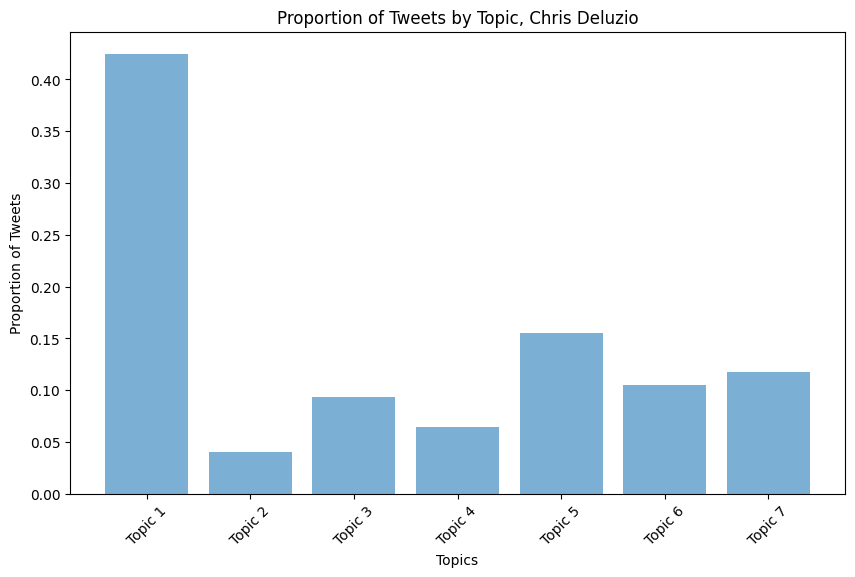

In [75]:
import matplotlib.pyplot as plt

# Calculate the sum of associations for each topic
topic_sums = W_abs.sum(axis=0)

# Normalize to get proportions
topic_proportions = topic_sums / topic_sums.sum()

# Topic labels (you can customize these to be more descriptive)
topic_labels = [f"Topic {i+1}" for i in range(num_topics)]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(topic_labels, topic_proportions, color='#7BAFD4')
plt.xlabel('Topics')
plt.ylabel('Proportion of Tweets')
plt.title('Proportion of Tweets by Topic, Chris Deluzio')
plt.xticks(rotation=45)
plt.savefig('deluzio_topic_distribution.png')
plt.show()


In [76]:
# new column with the broken up tweets
deluzio_tweets['tweet_text_with_breaks'] = deluzio_tweets['text'].apply(insert_line_breaks)

# Verify the results
print(deluzio_tweets[['text', 'tweet_text_with_breaks']].head())


                                                                                                                                                                                                                                                                 text  \
0                                                                                                I am honored and grateful that the people of #PA17 have elected me as their next Congressman to serve Western Pennsylvania in Congress. Read my full statement here:   
1                                                                                                                                              Polls are now open, #PA17! I’m out here at the polls in Aliquippa greeting folks and making sure they vote blue today!   
2                                                                                                                                                                           The sun might have went down, but

In [97]:
# Define your topic names based on your analysis
topic_names = [
    "Union Solidarity & Local Empowerment",
    "Reproductive Rights & Fighting Extremism",
    "Community Events",
    "Jobs & Infrastructure",
    "Advocacy",
    "Corporate Greed & Economic Fairness",
    "Defending Rights & Democracy"
]

# Create a new DataFrame for analysis
analysis_df = pd.DataFrame()

# Add the unprocessed tweet texts and tweet texts with line breaks
analysis_df['tweet_text'] = deluzio_tweets['text']
analysis_df['tweet_text_with_breaks'] = deluzio_tweets['tweet_text_with_breaks']  # Include the column with line breaks

# Add the association values for each topic with custom column names
for i, topic_name in enumerate(topic_names):
    analysis_df[topic_name] = W_abs[:, i]

analysis_df.head()


,tweet_text,tweet_text_with_breaks,Union Solidarity & Local Empowerment,Reproductive Rights & Fighting Extremism,Community Events,Jobs & Infrastructure,Advocacy,Corporate Greed & Economic Fairness,Defending Rights & Democracy
0,I am honored and grateful that the people of #PA17 have elected me as their next Congressman to serve Western Pennsylvania in Congress. Read my full statement here:,I am honored and grateful that the people of <br>#PA17 have elected me as their next Congressman <br>to serve Western Pennsylvania in Congress. Read <br>my full statement here:,0.168397,0.000000,0.093408,0.032413,0.199736,0.003377,0.196689
1,"Polls are now open, #PA17! I’m out here at the polls in Aliquippa greeting folks and making sure they vote blue today!","Polls are now open, #PA17! I’m out here at the <br>polls in Aliquippa greeting folks and making sure <br>they vote blue today!",0.227673,0.021324,0.107789,0.016599,0.062169,0.055184,0.066671
2,"The sun might have went down, but we are still out at the polls here in #PA17! Go vote! 🗳","The sun might have went down, but we are still <br>out at the polls here in #PA17! Go vote! 🗳",0.368849,0.065293,0.077563,0.000839,0.003172,0.050946,0.069821
3,"I ended the day at the polls at the place where it all began for me, in Thornburg where I grew up, where I learned the values I’ll take to Washington. #PA17","I ended the day at the polls at the place where <br>it all began for me, in Thornburg where I grew <br>up, where I learned the values I’ll take to <br>Washington. #PA17",0.222814,0.019093,0.043240,0.013794,0.235515,0.079841,0.053279
4,"Western PA made me the man I am today. From stepping up to serve this country in uniform, to fighting for our common good across #PA17, those values always guide me. And when I'm your Congressman, I will always put you, your families, and this country first.","Western PA made me the man I am today. From <br>stepping up to serve this country in uniform, to <br>fighting for our common good across #PA17, those <br>values always guide me. And when I'm your <br>Congressman, I will always put you, your <br>families, and this country first.",0.284166,0.016628,0.039511,0.039652,0.120440,0.000000,0.024107


In [98]:
sorted_topic_dfs = {}  # Initialize an empty dictionary to store sorted DataFrames for each topic

# Loop over all topic names and create a sorted DataFrame for each topic
for topic_name in topic_names:
    sorted_df = analysis_df.sort_values(by=topic_name, ascending=False)  # Sort by the current topic
    sorted_topic_dfs[topic_name] = sorted_df  # Store the sorted DataFrame in the dictionary


In [99]:
# Using the format 'Topic_X'
display_top_tweets('Topic_1', 30)

,tweet_text,Union Solidarity & Local Empowerment,Reproductive Rights & Fighting Extremism,Community Events,Jobs & Infrastructure,Advocacy,Corporate Greed & Economic Fairness,Defending Rights & Democracy
509,💯 @JohnFetterman\n — let’s get to work!,0.492941,0.070022,0.055679,0.013468,0.000000,0.042314,0.145391
156,This one never gets old...,0.432301,0.055879,0.074762,0.000000,0.020781,0.125343,0.000000
472,"Let's make stuff in this country, let's have our union brothers and sisters make it right here in #PA17, and let's get to work.",0.425112,0.041721,0.060135,0.005158,0.000000,0.011175,0.080680
370,This is what people power looks like.,0.424522,0.051766,0.042700,0.010049,0.077440,0.060903,0.000000
433,As true today as ever...,0.396392,0.061030,0.093090,0.031988,0.070898,0.019123,0.021504
206,#PA17 rocks hard. Great stuff!,0.382983,0.046133,0.073945,0.000000,0.000000,0.085150,0.084873
401,#TeamDeluzio has the best volunteers in the game. Thank you for your hard work today all across #PA17. Especially the team at @MomsDemand\n.\n\nWe could always use more help: https://mobilize.us/chrisforpa/,0.371273,0.032472,0.056692,0.041407,0.000000,0.014951,0.030589
2,"The sun might have went down, but we are still out at the polls here in #PA17! Go vote! 🗳",0.368849,0.065293,0.077563,0.000839,0.003172,0.050946,0.069821
426,"The last thing we need is yet another healthcare monopoly. @JeffBezos\n has no business in your doctor's office. If anything, he could stand to lose a few companies. #BreakEmUp",0.364572,0.026724,0.036774,0.059199,0.000000,0.012862,0.050896
136,It was great to spend time talking with really sharp new and future voters at Moon High School this morning.\n\nThe future of #PA17 is bright!,0.363561,0.044499,0.060281,0.000000,0.030634,0.043090,0.000000


In [100]:
# Melt the analysis_df DataFrame to "long" format including both tweet text columns
melted_df_deluzio = analysis_df.melt(id_vars=['tweet_text', 'tweet_text_with_breaks'], 
                             value_vars=topic_names,
                             var_name='Topic', 
                             value_name='Weight')

# Filter the top 50 tweets for each topic by weight
top_tweets_per_topic_deluzio = melted_df_deluzio.groupby('Topic').apply(lambda x: x.nlargest(50, 'Weight')).reset_index(drop=True)

/var/folders/g8/fr69kqs91h18pky6rxzz178w0000gn/T/ipykernel_49701/3491505679.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_tweets_per_topic_deluzio = melted_df_deluzio.groupby('Topic').apply(lambda x: x.nlargest(50, 'Weight')).reset_index(drop=True)


In [101]:
top_tweets_per_topic_deluzio

,tweet_text,tweet_text_with_breaks,Topic,Weight
0,I will do everything I can to protect women’s freedom! #PA17Debate,I will do everything I can to protect women’s <br>freedom! #PA17Debate,Advocacy,0.387204
1,I'm in this race to fight corporate greed and strengthen our democracy.,I'm in this race to fight corporate greed and <br>strengthen our democracy.,Advocacy,0.363076
2,"I've been committed to defending our Constitution since I took the oath as a 17-year old, and my resolve to defend America and our freedom has only grown. [2/2]","I've been committed to defending our Constitution <br>since I took the oath as a 17-year old, and my <br>resolve to defend America and our freedom has <br>only grown. [2/2]",Advocacy,0.327523
3,Unions lift up all workers and strengthen our democracy. ✊,Unions lift up all workers and strengthen our <br>democracy. ✊,Advocacy,0.327167
4,"Happy #VFWDay from this proud VFW member! And thanks for all that you do for us veterans, service members, and our families.","Happy #VFWDay from this proud VFW member! And <br>thanks for all that you do for us veterans, <br>service members, and our families.",Advocacy,0.325263
...,...,...,...,...
345,"#TeamDeluzio has been knocking on doors, and we are hearing the same thing. Life is too expensive, our union jobs have been shipped overseas, and we should be making stuff here again. Join the team that's ready to get stuff done for working families: https://mobilize.us/chrisforpa/","#TeamDeluzio has been knocking on doors, and we <br>are hearing the same thing. Life is too <br>expensive, our union jobs have been shipped <br>overseas, and we should be making stuff here <br>again. Join the team that's ready to get stuff <br>done for working families: <br>https://mobilize.us/chrisforpa/",Union Solidarity & Local Empowerment,0.330335
346,Thanks to some wonderful folks in Chippewa for hosting a meet and greet for #TeamDeluzio this afternoon. Got to see some old friends and make some new ones! #PA17,Thanks to some wonderful folks in Chippewa for <br>hosting a meet and greet for #TeamDeluzio this <br>afternoon. Got to see some old friends and make <br>some new ones! #PA17,Union Solidarity & Local Empowerment,0.330299
347,Thanks to all the folks who came out for our #TeamDeluzio office opening party tonight in Coraopolis. Let's win this! @LindseyForPA,Thanks to all the folks who came out for our <br>#TeamDeluzio office opening party tonight in <br>Coraopolis. Let's win this! @LindseyForPA,Union Solidarity & Local Empowerment,0.330234
348,"Great to tour ATI Brackenridge and spend time with the \n@steelworkers\n members whose hard work makes the place run. We have the workers and businesses that know how to make stuff right here in western PA, and I'll always fight for our union manufacturing jobs in #PA17.","Great to tour ATI Brackenridge and spend time <br>with the @steelworkers members whose hard work <br>makes the place run. We have the workers and <br>businesses that know how to make stuff right here <br>in western PA, and I'll always fight for our <br>union manufacturing jobs in #PA17.",Union Solidarity & Local Empowerment,0.330164


In [103]:
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import jitter, factor_cmap  # Corrected import
from bokeh.palettes import Category20  # Import a palette with enough colors
import pandas as pd
import numpy as np

output_notebook()

# top_tweets_per_topic_deluziois the DataFrame we just prepared 
top_tweets_per_topic_deluzio['Weight_Jittered'] = top_tweets_per_topic_deluzio['Weight'] + np.random.uniform(-0.02, 0.02, 
                                                    size=top_tweets_per_topic_deluzio.shape[0])
source = ColumnDataSource(top_tweets_per_topic_deluzio)

# Create unique list of topics for color mapping
unique_topics = top_tweets_per_topic_deluzio['Topic'].unique().tolist()

p2 = figure(sizing_mode="inherit", x_range=unique_topics, tools="")
# Adjust the title
p2.title.text = "Top 50 Tweets in Each Topic  - Chris Deluzio"  # Set the title text
p2.title.align = 'center'  # Center the title
p2.title.text_font_size = '16pt'  # Increase the title font size
p2.title.text_font = "helvetica"  # Optional: Change the font type
p2.title.text_color = "DarkSlateGrey"  # Optional: Change the font color

# Use factor_cmap for color differentiation
p2.circle(x=jitter('Topic', width=0.6, range=p2.x_range), y='Weight_Jittered', source=source, size=10,
         line_color='DarkSlateGrey', fill_alpha=0.6, hover_fill_color='firebrick', hover_alpha=1.0,
         color=factor_cmap('Topic', palette=Category20[len(unique_topics)], factors=unique_topics))

hover = HoverTool()
hover.tooltips = [("Tweet", "@tweet_text_with_breaks{safe}")]
p2.add_tools(hover)

# Customize label sizes and styles
p2.xaxis.major_label_orientation = 0.6  # 45-degree tilt
p2.xaxis.major_label_text_font_size = "12pt"
p2.yaxis.major_label_text_font_size = "12pt"

p2.xaxis.axis_label = "Topic"
p2.yaxis.axis_label = "Weight"
p2.axis.axis_label_text_font_size = "14pt"

p2.grid.grid_line_alpha = 0.3

show(p2)


Loading BokehJS ...

In [105]:
import pandas as pd

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool


output_file('deluzio_topics1.html')

show(p2)